# Task 1:

Regenerate the results in STORM algorithm paper, https://arxiv.org/pdf/1905.10018.pdf

The results require the use of ResNet model and CIFAR10 datasets.

Hint1: Use the lab GPU to acclerate the training

Hint2: Using torch.optim for other methods (not STORN) is accepted.


In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.optimizer import Optimizer
from torchsummary import summary

torch.cuda.manual_seed_all(143)

#setting device configuration
device=torch.device("cuda" if torch.cuda.is_available else "cpu")


#setting transforms for train and test sets
train_tfs = transforms.Compose([transforms.RandomCrop(32,padding=4),
                                transforms.RandomHorizontalFlip(p=0.7),transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,.225])])

test_tfs = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

#loading and preparing data
train_data = datasets.CIFAR10(root=r"C:\Users\Darshan Khandelwal\OneDrive\Desktop\data",download=True,transform=train_tfs,train=True)
size_train = len(train_data) // 1
train_data = torch.utils.data.Subset(train_data, indices=range(size_train))
print(len(train_data))
trainloader = DataLoader(dataset=train_data,batch_size=128,shuffle=True)
test_data = datasets.CIFAR10(root=r"C:\Users\Darshan Khandelwal\OneDrive\Desktop\data",download=False,transform=test_tfs,train=False)
size_test = len(test_data) // 1
test_data = torch.utils.data.Subset(test_data, indices=range(size_test))
print(len(test_data))
testloader = DataLoader(dataset=test_data,batch_size=128)

#10 classes of CIFAR10
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']



Files already downloaded and verified
50000
10000


In [36]:

def build_model(trainloader,testloader,device,model,criterion,optimizer,scheduler,num_epochs,classes,batch_size):
  train_loss=[]
  train_accuracy=[]
  test_accuracy=[]

  #training our model
  for e in range(num_epochs):
    tr_loss=0
    model.train()
    n_samples_train = 0
    n_correct_train = 0
    for (samples,labels) in trainloader:
      samples = samples.to(device)
      labels = labels.to(device)
      #model predictions
      y_predicted = model(samples)
      #cost
      cost = criterion(y_predicted,labels)
      tr_loss+=cost.item()
      #calculate gradients
      cost.backward()
      #update parameters
      optimizer.step()
      #avoid accumulation of gradients
      optimizer.zero_grad()
      #taking a step of scheduler(not required in case of storm optimizer)
      if scheduler is not None:
        scheduler.step()
      #checking accuracy after this many epochs
      _,prediction = torch.max(y_predicted,1)
      n_samples_train+= labels.shape[0]
      n_correct_train+= (prediction == labels).sum().item()

    acc = 100*n_correct_train/(float)(n_samples_train)
    train_accuracy.append(acc)

    #printing loss per 10 epochs
    tr_loss=tr_loss/len(trainloader)
    if (e+1)%10 == 0:
      print("epoch:",e+1,"/",num_epochs," loss:{0:.4f}".format(tr_loss))
    train_loss.append(tr_loss)



    #calculating test accuracy per epoch
    with torch.no_grad():
      model.eval()
      n_samples_test = 0
      n_correct_test = 0
      for (samples,labels) in testloader:
        samples = samples.to(device)
        labels = labels.to(device)
        y_pred = model(samples)
        _,prediction = torch.max(y_pred,1)
        n_samples_test+= labels.shape[0]
        n_correct_test+= (prediction == labels).sum().item()
      acc = 100*n_correct_test/(float)(n_samples_test)
      test_accuracy.append(acc)

  #evaluating our trained model on test data
  with torch.no_grad():
    model.eval()
    n_samples = 0
    n_correct = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for (samples,labels) in testloader:
      samples = samples.to(device)
      labels = labels.to(device)
      y_pred = model(samples)
      _,prediction = torch.max(y_pred,1)
      n_samples+= labels.shape[0]
      n_correct+= (prediction == labels).sum().item()
      if labels.shape[0] != batch_size:
        batch_size = labels.shape[0]
      for i in range(batch_size):
        label = labels[i].item()
        predict = prediction[i].item()
        if label == predict:
          n_class_correct[label]+= 1
        n_class_samples[label]+= 1

  #printing overall accuracy
  accuracy = 100*n_correct/(float)(n_samples)
  print("\n")
  print("Overall accuracy of system: {0:.2f}%".format(accuracy))

  #printing accuracy of each class
  for i in range(10):
    acc=100*n_class_correct[i]/n_class_samples[i]
    print("Accuracy of",classes[i],"= {:.2f}%".format(acc))

  return train_loss,train_accuracy,test_accuracy


In [37]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 23 00:27:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |    665MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
#setting device configuration
device=torch.device("cuda" if torch.cuda.is_available else "cpu")

def ResNet32():
  class Basic_Module(nn.Module):
    #Basic Block with identity maps as shortcuts
    def __init__(self,in_channel,out_channel,stride=1):
      super(Basic_Module,self).__init__()
      self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=3,stride=stride,padding=1,bias=False)
      self.bn1 = nn.BatchNorm2d(out_channel)
      self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channel)
      self.shortcut = nn.Sequential()

      if stride!=1 or in_channel!=out_channel:
        self.shortcut = nn.Sequential(
                          nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=stride,bias=False),
                          nn.BatchNorm2d(out_channel))

    def forward(self,x):
      x_shortcut = x
      x = torch.celu(self.bn1(self.conv1(x)),alpha=0.075)
      x = self.bn2(self.conv2(x))
      x_shortcut = self.shortcut(x_shortcut)
      #creating a shortcut connection
      x = x + x_shortcut
      x = torch.celu(x,alpha=0.075)
      return x

  class Bottleneck_Module(nn.Module):
    #Bottleneck block with identity map as shortcuts
    def __init__(self,in_channel,out_channel,stride=1):
      super(Bottleneck_Module,self).__init__()
      self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=1,padding=0,bias=False)
      self.bn1 = nn.BatchNorm2d(out_channel)
      self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channel)
      self.conv3 = nn.Conv2d(out_channel,out_channel,kernel_size=1,padding=0,bias=False,stride=stride)
      self.bn3 = nn.BatchNorm2d(out_channel)
      self.shortcut = nn.Sequential()

      if stride!=1 or in_channel!=out_channel:
        self.shortcut = nn.Sequential(
                          nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=stride,bias=False),
                          nn.BatchNorm2d(out_channel))

    def forward(self,x):
      x_shortcut = x
      x = torch.celu(self.bn1(self.conv1(x)),alpha=0.075)
      x = torch.celu(self.bn2(self.conv2(x)),alpha=0.075)
      x = self.bn3(self.conv3(x))
      x_shortcut = self.shortcut(x_shortcut)
      #creating a shortcut connection
      x = x + x_shortcut
      x = torch.celu(x,alpha=0.075)
      return x

  class ResNet(nn.Module):
    #main resnet model
    def __init__(self,block,filter_map,n,classes=10):
      super(ResNet,self).__init__()
      self.conv1 = nn.Conv2d(3,filter_map[0],kernel_size=3,padding=1,bias=False)
      self.bn1 = nn.BatchNorm2d(filter_map[0])
      self.block1 = self.MakeResnetLayer(block,(filter_map[0],filter_map[0]),n,stride=1)
      self.block2 = self.MakeResnetLayer(block,(filter_map[0],filter_map[1]),n,stride=2)
      self.block3 = self.MakeResnetLayer(block,(filter_map[1],filter_map[2]),n,stride=2)
      self.GloabalAveragePool = nn.AdaptiveAvgPool2d(2)
      self.fc = nn.Linear(2*2*filter_map[2],classes,bias=True)

    def MakeResnetLayer(self,block,filters,n,stride):
      #defining filters
      in_channel,out_channel = filters
      #layers to be added at given stage
      layer = []
      layer.append(block(in_channel,out_channel,stride))
      for i in range(n-1):
        layer.append(block(out_channel,out_channel))
      #stacking all layers
      SubBlock = nn.Sequential(*layer)
      return SubBlock

    def forward(self,x):
      #initial layers
      x = torch.relu(self.bn1(self.conv1(x)))
      #stage1
      x = self.block1(x)
      #stage2
      x = self.block2(x)
      #stage3
      x = self.block3(x)
      #final layers
      x = self.GloabalAveragePool(x)
      x = x.view(-1,2*2*64)
      x = self.fc(x)
      return x

  #creating an object of resnet model and pushing it to device(CPU/GPU)
  model1 = ResNet(Basic_Module,[16,32,64],5).to(device)
  model2 = ResNet(Bottleneck_Module,[16,32,64],5).to(device)
  return model1,model2





In [39]:
import copy

#hyperparameters and dictionaries(for STORM optimizer)
num_epochs=80
learn_rate=0.1
batch_size=128
c=100
momentum={}
gradient={}
sqrgradnorm={}

#defining the loss criteria to be used
criterion = nn.CrossEntropyLoss()

#defining models
ModelBasic,ModelBottleneck1 = ResNet32()
ModelBottleneck2 = copy.deepcopy(ModelBottleneck1)
ModelBottleneck3 = copy.deepcopy(ModelBottleneck1)
ModelBottleneck4 = copy.deepcopy(ModelBottleneck1)


In [40]:


optimizer1 = optim.Adam(ModelBottleneck1.parameters(),lr=learn_rate)
scheduler1 = MultiStepLR(optimizer1,milestones=[50,70],gamma=0.5)

print("ADAM OPTIMIZER::\n")
tr_loss1,tr_acc1,test_acc1 = build_model(trainloader,testloader,device,ModelBottleneck1,criterion,optimizer1,scheduler1,num_epochs,classes,batch_size)

ADAM OPTIMIZER::

epoch: 10 / 80  loss:1.0366
epoch: 20 / 80  loss:0.7577
epoch: 30 / 80  loss:0.6256
epoch: 40 / 80  loss:0.5563
epoch: 50 / 80  loss:0.4999
epoch: 60 / 80  loss:0.4580
epoch: 70 / 80  loss:0.4198
epoch: 80 / 80  loss:0.3994


Overall accuracy of system: 62.72%
Accuracy of plane = 48.00%
Accuracy of car = 58.20%
Accuracy of bird = 87.10%
Accuracy of cat = 73.90%
Accuracy of deer = 82.80%
Accuracy of dog = 33.60%
Accuracy of frog = 38.80%
Accuracy of horse = 55.60%
Accuracy of ship = 88.70%
Accuracy of truck = 60.50%


In [41]:


optimizer2 = optim.Adagrad(ModelBottleneck2.parameters(),lr=learn_rate)
scheduler2 = MultiStepLR(optimizer2,milestones=[50,70],gamma=0.7)

print("ADAGRAD OPTIMIZER::\n")
tr_loss2,tr_acc2,test_acc2 = build_model(trainloader,testloader,device,ModelBottleneck2,criterion,optimizer2,scheduler2,num_epochs,classes,batch_size)

ADAGRAD OPTIMIZER::

epoch: 10 / 80  loss:0.8432
epoch: 20 / 80  loss:0.5640
epoch: 30 / 80  loss:0.4332
epoch: 40 / 80  loss:0.3600
epoch: 50 / 80  loss:0.3078
epoch: 60 / 80  loss:0.2641
epoch: 70 / 80  loss:0.2361
epoch: 80 / 80  loss:0.2086


Overall accuracy of system: 67.89%
Accuracy of plane = 69.60%
Accuracy of car = 64.40%
Accuracy of bird = 62.90%
Accuracy of cat = 69.20%
Accuracy of deer = 87.90%
Accuracy of dog = 47.40%
Accuracy of frog = 81.10%
Accuracy of horse = 58.30%
Accuracy of ship = 76.80%
Accuracy of truck = 61.30%


In [42]:
import torch
from torch.optim import Optimizer

class StormOptimizer(Optimizer):
    def __init__(self, params, lr=0.1, c=100, momentum={}, gradient={}, sqrgradnorm={}):
        defaults = dict(lr=lr, c=c, momentum=momentum, sqrgradnorm=sqrgradnorm, gradient=gradient)
        super(StormOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            learn_rate = group['lr']
            factor = group['c']
            momentum = group['momentum']
            gradient = group['gradient']
            sqrgradnorm = group['sqrgradnorm']

            for p in group['params']:
                if p.grad is None:
                    continue
                dp = p.grad.data

                # Only store the last two gradients
                if p in gradient:
                    gradient[p].append(dp)
                    if len(gradient[p]) > 2:
                        gradient[p].pop(0)
                else:
                    gradient[p] = [dp]

                # Calculating and storing ∑G^2 in sqrgradnorm
                if p in sqrgradnorm:
                    sqrgradnorm[p] = sqrgradnorm[p] + torch.pow(torch.norm(dp), 2)
                else:
                    sqrgradnorm.update({p: torch.pow(torch.norm(dp), 2)})

                # Updating learning rate ('η' in paper)
                power = 1.0 / 3.0
                scaling = torch.pow((0.1 + sqrgradnorm[p]), power)
                learn_rate = learn_rate / (float)(scaling)

                # Calculating 'a' mentioned as a=cη^2 in paper (denoted 'c' as factor here)
                a = min(factor * learn_rate ** 2.0, 1.0)

                # Calculating and storing the momentum term (d'=∇f(x',ε')+(1-a')(d-∇f(x,ε')))
                if p in momentum:
                    momentum[p] = gradient[p][-1] + (1 - a) * (momentum[p] - gradient[p][-2])
                else:
                    momentum.update({p: dp})

                # Updation of model parameter p
                p.data = p.data - learn_rate * momentum[p]
                learn_rate = group['lr']

        return loss


In [43]:

optimizer3 = StormOptimizer(ModelBottleneck3.parameters(),learn_rate,c,momentum,gradient,sqrgradnorm)
scheduler3 = None   #learning rate is already modified inside optimizer so there is no need of lr_scheduler

print("STORM OPTIMIZER::\n")
tr_loss3,tr_acc3,test_acc3 = build_model(trainloader,testloader,device,ModelBottleneck3,criterion,optimizer3,scheduler3,num_epochs,classes,batch_size)

STORM OPTIMIZER::

epoch: 10 / 80  loss:0.8801
epoch: 20 / 80  loss:0.6854
epoch: 30 / 80  loss:0.5734
epoch: 40 / 80  loss:0.5035
epoch: 50 / 80  loss:0.4462
epoch: 60 / 80  loss:0.4020
epoch: 70 / 80  loss:0.3643
epoch: 80 / 80  loss:0.3376


Overall accuracy of system: 63.33%
Accuracy of plane = 57.30%
Accuracy of car = 56.70%
Accuracy of bird = 67.30%
Accuracy of cat = 65.80%
Accuracy of deer = 80.70%
Accuracy of dog = 35.80%
Accuracy of frog = 78.40%
Accuracy of horse = 47.00%
Accuracy of ship = 81.30%
Accuracy of truck = 63.00%


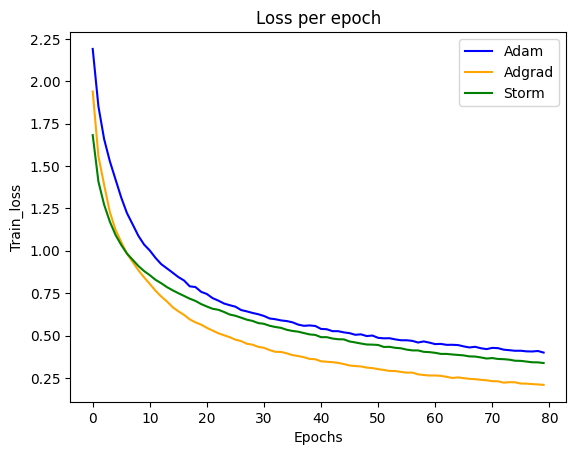

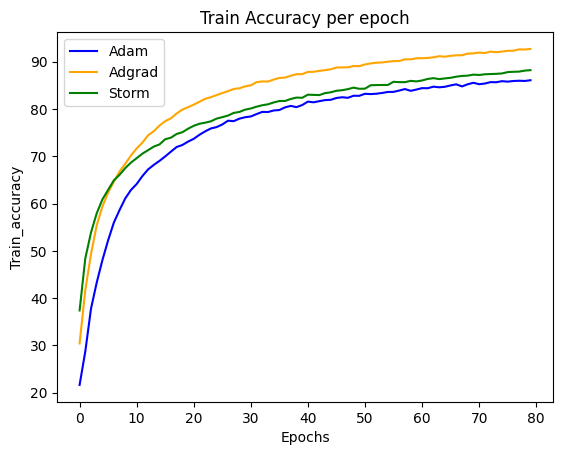

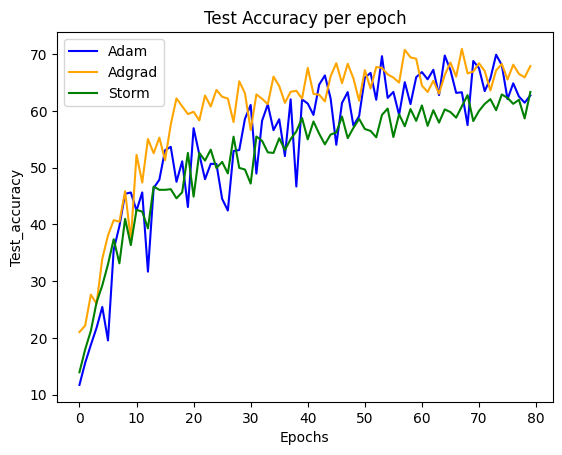

In [44]:
#plotting train_loss per epoch
plt.plot(tr_loss1,color="b",label="Adam")
plt.plot(tr_loss2,color="orange",label="Adgrad")
plt.plot(tr_loss3,color="g",label="Storm")
plt.xlabel("Epochs")
plt.ylabel("Train_loss")
plt.title("Loss per epoch")
plt.legend()
plt.show()

#plotting train_accuracy per epoch
plt.plot(tr_acc1,color="b",label="Adam")
plt.plot(tr_acc2,color="orange",label="Adgrad")
plt.plot(tr_acc3,color="g",label="Storm")
plt.xlabel("Epochs")
plt.ylabel("Train_accuracy")
plt.title("Train Accuracy per epoch")
plt.legend()
plt.show()

#plotting test_accuracy per epoch
plt.plot(test_acc1,color="b",label="Adam")
plt.plot(test_acc2,color="orange",label="Adgrad")
plt.plot(test_acc3,color="g",label="Storm")
plt.xlabel("Epochs")
plt.ylabel("Test_accuracy")
plt.title("Test Accuracy per epoch")
plt.legend()
plt.show()

# Task 2:

Adjust the feature scaling property in STORM to other method and compare the results to original STORM.

Hint: You can use methods from previous labs (e.g. adaDelta)


In [45]:
import torch
from torch.optim import Optimizer

class NewStormOptimizer(Optimizer):
    def __init__(self, params, lr=0.1, c=100, momentum={}, gradient={}, sqrgradnorm={}, rho=0.9):
        defaults = dict(lr=lr, c=c, momentum=momentum, sqrgradnorm=sqrgradnorm, gradient=gradient, rho=rho)
        super(NewStormOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            learn_rate = group['lr']
            factor = group['c']
            momentum = group['momentum']
            gradient = group['gradient']
            sqrgradnorm = group['sqrgradnorm']
            rho = group['rho']

            for p in group['params']:
                if p.grad is None:
                    continue
                dp = p.grad.data

                # Only store the last two gradients
                if p in gradient:
                    gradient[p].append(dp)
                    if len(gradient[p]) > 2:
                        gradient[p].pop(0)
                else:
                    gradient[p] = [dp]

                # Calculating and storing ∑G^2 in sqrgradnorm
                if p in sqrgradnorm:
                    sqrgradnorm[p] = rho * sqrgradnorm[p] + (1-rho) * torch.pow(torch.norm(dp), 2)
                else:
                    sqrgradnorm.update({p: torch.pow(torch.norm(dp), 2)})

                # Updating learning rate ('η' in paper)
                power = 1.0 / 3.0
                scaling = torch.pow((0.1 + sqrgradnorm[p]), power)
                learn_rate = learn_rate / (float)(scaling)

                # Calculating 'a' mentioned as a=cη^2 in paper (denoted 'c' as factor here)
                a = min(factor * learn_rate ** 2.0, 1.0)

                # Calculating and storing the momentum term (d'=∇f(x',ε')+(1-a')(d-∇f(x,ε')))
                if p in momentum:
                    momentum[p] = gradient[p][-1] + (1 - a) * (momentum[p] - gradient[p][-2])
                else:
                    momentum.update({p: dp})

                # Updation of model parameter p
                p.data = p.data - learn_rate * momentum[p]
                learn_rate = group['lr']

        return loss


In [46]:

rho=0.9
optimizer4 = NewStormOptimizer(ModelBottleneck4.parameters(),learn_rate,c,momentum, gradient, sqrgradnorm, rho=0.9)
scheduler4 = None   #learning rate is already modified inside optimizer so there is no need of lr_scheduler

print("STORM OPTIMIZER::\n")
tr_loss4,tr_acc4,test_acc4 = build_model(trainloader,testloader,device,ModelBottleneck4,criterion,optimizer4,scheduler4,num_epochs,classes,batch_size)

STORM OPTIMIZER::

epoch: 10 / 80  loss:0.5396
epoch: 20 / 80  loss:0.3690
epoch: 30 / 80  loss:0.2840
epoch: 40 / 80  loss:0.2342
epoch: 50 / 80  loss:0.1917
epoch: 60 / 80  loss:0.1628
epoch: 70 / 80  loss:0.1426
epoch: 80 / 80  loss:0.1308


Overall accuracy of system: 76.58%
Accuracy of plane = 71.40%
Accuracy of car = 79.50%
Accuracy of bird = 85.90%
Accuracy of cat = 70.50%
Accuracy of deer = 83.30%
Accuracy of dog = 68.70%
Accuracy of frog = 81.70%
Accuracy of horse = 65.00%
Accuracy of ship = 79.60%
Accuracy of truck = 80.20%


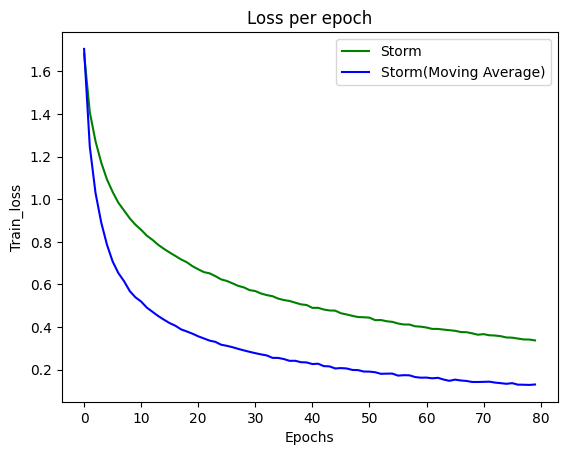

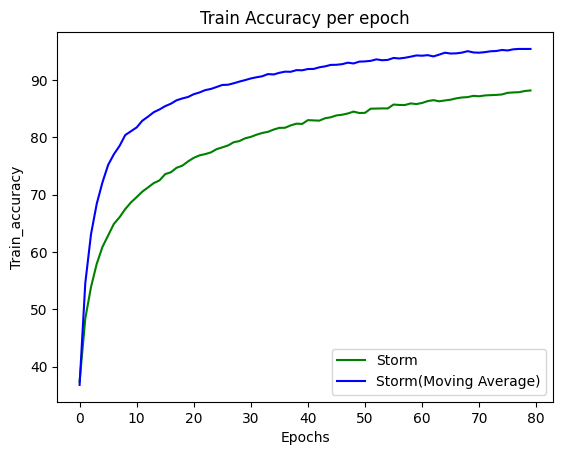

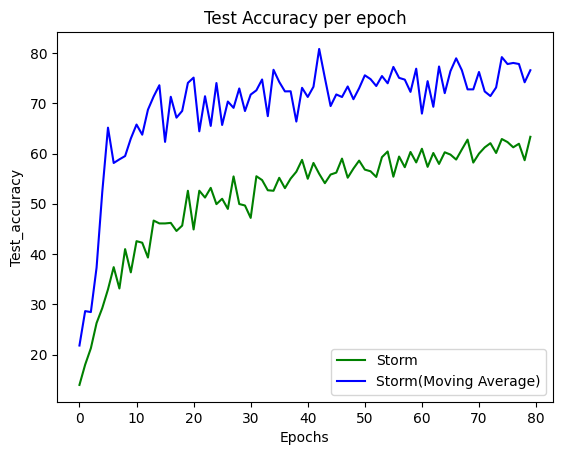

In [47]:
#plotting train_loss per epoch
plt.plot(tr_loss3,color="g",label="Storm")
plt.plot(tr_loss4,color="b",label="Storm(Moving Average)")
plt.xlabel("Epochs")
plt.ylabel("Train_loss")
plt.title("Loss per epoch")
plt.legend()
plt.show()

#plotting train_accuracy per epoch
plt.plot(tr_acc3,color="g",label="Storm")
plt.plot(tr_acc4,color="b",label="Storm(Moving Average)")
plt.xlabel("Epochs")
plt.ylabel("Train_accuracy")
plt.title("Train Accuracy per epoch")
plt.legend()
plt.show()

#plotting test_accuracy per epoch
plt.plot(test_acc3,color="g",label="Storm")
plt.plot(test_acc4,color="b",label="Storm(Moving Average)")
plt.xlabel("Epochs")
plt.ylabel("Test_accuracy")
plt.title("Test Accuracy per epoch")
plt.legend()
plt.show()

# Task3 :

Discuss the drawback of STORM algorithm (if any) and compare it to ADAM, in terms of convergence speed, and complexity.

Drawbacks of STORM:

Hyperparameter Sensitivity: STORM has multiple hyperparameters that need to be tuned, which can make it sensitive to the specific choice of hyperparameters. Selecting the right set of hyperparameters for a given problem can be challenging.

Stability: In some cases, STORM might exhibit instability, particularly if the chosen hyperparameters are not well-suited to the specific optimization landscape of the problem at hand.

Scalability: While STORM can be effective for a variety of problems, it may not scale as well as some other algorithms to very large datasets or extremely high-dimensional parameter spaces.

Comparatively, the ADAM (Adaptive Moment Estimation) optimizer is another widely used optimization algorithm in the training of deep neural networks.

Comparison of STORM and ADAM:

Convergence Speed:

ADAM generally exhibits faster convergence in comparison to many other optimization algorithms, including STORM, especially in settings with noisy gradients or non-stationary objectives.
STORM, while designed for fast convergence, might require more careful tuning of hyperparameters to achieve similar convergence speeds as ADAM in some scenarios.
Complexity:

Both ADAM and STORM have similar computational complexity per iteration, as they both maintain moving averages and adapt learning rates for each parameter.
However, the complexity in practice can depend on the ease of tuning and the stability of the algorithms on the specific problem, where ADAM often has an advantage due to its widespread use and extensive empirical validation.
Robustness:

ADAM is known for its robustness and has been extensively used and validated across a wide range of problems and domains.
STORM might exhibit less robustness in comparison, especially with poorly chosen hyperparameters.
Hyperparameter Tuning:

ADAM is usually less sensitive to the exact choice of hyperparameters and often works well with the default settings, making it user-friendly for practitioners.
STORM might require more effort in tuning the hyperparameters for optimal performance on a given problem.
In conclusion, while STORM offers an interesting approach to optimization and can be effective in certain scenarios, ADAM is often preferred for its robustness, fast convergence, and ease of use. However, the choice of optimization algorithm should always be guided by the specific characteristics of the problem at hand, and empirical validation is crucial for assessing the performance of different optimizers.